# Analisis de la serie de tiempo de Precipitaciones Para el modelo ARIMA
Con este reporte se rpetende tener un analisis completo para determinar la calidad de la informacion y asi pider utilizar los datos para encontrar correlacion y analisis de la serie temporal, con la finalidad de crear un modelo predictivo para imputar sesgos.

In [1]:
from utils.utils import get_df_serie_temporal, agregar_columna_mes, categorize_precipitation, reshample_time_serie, describe_historical_serie, autocorrelacion
from graphics_utils.express import fig_boxplot, fig_lineplot, fig_pie_month, fig_pie, fig_boxplot_category, fig_histogram
from statistics_utils.eda.timeseries import decompose_time_series, test_stationarity, correlation
#from figuras import combined_figures
from api_somo import fetch_and_process_data, fetch_qf
#from imputations import imputar_knn
from graphics_utils.go import multi_scatter, multi_boxplot, multi_line, autocorrelogram, arrange_figures_in_subplots
import kaleido
import ephem
import numpy as np
import pandas as pd

In [2]:
# PARAMETROS PARA OBTENER SERIE DE TIEMPO DESDE LAS APIS
api_filtrate_seire = "http://127.0.0.1:8000/time-series/qfcontroler/filtrate_time_serie/"

params = {
        "station_name": "tumaco",
        "variable_name": "Precipitación acumulada",
        "processing_level_name": "Control de calidad",
        "start_date": "2009-01-01",
        "end_date": "2009-12-31"
        }


In [3]:
# OBTENCION DE SERIES 

# serie insitu en df
insitu = fetch_and_process_data(api_filtrate_seire, params)
print(insitu)
pie_fig = fig_pie_month(insitu,params)
pie_fig.show()

                           value  quality_factor__quality_flag  month
timestamp                                                            
2009-02-01 05:10:00+00:00    0.0                             1      2
2009-02-01 05:20:00+00:00    0.0                             1      2
2009-02-01 05:30:00+00:00    0.0                             1      2
2009-02-01 05:40:00+00:00    0.0                             1      2
2009-02-01 05:50:00+00:00    0.0                             1      2
...                          ...                           ...    ...
2009-12-31 04:20:00+00:00    0.0                             1     12
2009-12-31 04:30:00+00:00    0.0                             1     12
2009-12-31 04:40:00+00:00    0.0                             1     12
2009-12-31 04:50:00+00:00    0.0                             1     12
2009-12-31 05:00:00+00:00    0.0                             1     12

[47952 rows x 3 columns]


KeyError: 'qf'

# Calida de la serie de riempo por meses
Esta grafica muestra el porcentaje de datos buenos por mes que tiene la serie en cuestion, con el fin de analizar los posibles errores asociados a la metodologia.

In [5]:
# PRE-PROCESAMIENTO DE LAS SERIES
insitu.loc[insitu['qf'] != 1, 'value'] = np.nan
#insitu = categorize_precipitation(insitu, params)
diario = reshample_time_serie(insitu, 'D', 'sum')
# Calcular fase lunar para cada fecha en el índice de `diario`
fases_lunares = []
for fecha in diario.index:
    moon = ephem.Moon()
    moon.compute(fecha.strftime('%Y-%m-%d'))  # Convertir a formato compatible
    fases_lunares.append(moon.phase)

# Agregar fase lunar al DataFrame
diario['fase_lunar'] = fases_lunares

# Mostrar resultados
e=multi_line(NM=insitu['value'], MO=diario['fase_lunar'])
e.show()
#diario = categorize_precipitation(diario, params)


In [6]:
boxplot = fig_boxplot(diario, params)
boxplot.show()

# Distribucion de la precipitacion en el año
Aqui se puede analizar cual fue el comportameinto estadistico de la serie temporal, vemos las tendencias y estacionallidades.

In [7]:
test_stationarity(diario['value'])

Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico de Prueba: -5.150835403841771
Valor P: 1.1068686256456426e-05
Número de Retardos Usados: 7
Número de Observaciones: 326
Valores Críticos:
  1%: -3.4505694423906546
  5%: -2.8704469462727795
  10%: -2.5715154495841017

La serie es estacionaria (se rechaza H₀).


In [8]:
# Calcular la primera diferenciación
diferenciada = diario.copy()
diferenciada['value'] = diario['value'].diff()  # Calcular la diferencia
diferenciada = diferenciada.dropna(subset=['value'])  # Eliminar filas con NaN en 'value'
# Validar que no hay NaN o Inf en la columna 'value'
diferenciada = diferenciada[~diferenciada['value'].isin([np.inf, -np.inf])]  # Eliminar Inf
# Prueba de estacionariedad
test_stationarity(diferenciada['value'])


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico de Prueba: -11.365817960136443
Valor P: 9.232736187050811e-21
Número de Retardos Usados: 8
Número de Observaciones: 324
Valores Críticos:
  1%: -3.450695263332383
  5%: -2.87050218926466
  10%: -2.5715449066453284

La serie es estacionaria (se rechaza H₀).


In [9]:

# Segunda diferenciación (doble diferenciación)
diferenciada_2 = diario.copy()
diferenciada_2['value'] = diferenciada['value'].diff()
diferenciada_2 = diferenciada_2.dropna(subset=['value'])  # Eliminar filas con NaN en 'value'
# Validar que no hay NaN o Inf en la columna 'value'
diferenciada_2 = diferenciada_2[~diferenciada_2['value'].isin([np.inf, -np.inf])]  # Eliminar Inf
# Prueba de estacionariedad
test_stationarity(diferenciada_2['value'])


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico de Prueba: -9.165173858482506
Valor P: 2.4718305735966493e-15
Número de Retardos Usados: 17
Número de Observaciones: 314
Valores Críticos:
  1%: -3.4513486122290717
  5%: -2.870789013306053
  10%: -2.5716978530569192

La serie es estacionaria (se rechaza H₀).


In [10]:
import figuras


line = multi_line(Original=diario['value'], Diferencia1=diferenciada['value'], Diferencia2 = diferenciada_2['value'])
histograma = fig_histogram(diario, params)
histograma_dif = fig_histogram(diferenciada, params)
histograma_dif2 = fig_histogram(diferenciada_2, params)
figuras_h={
    'line':line,
    'histograma': histograma,
    'histograma_dif':histograma_dif,
    'histograma_dif2':histograma_dif2
}
fig = arrange_figures_in_subplots(list(figuras_h.values()), 2, 2)
fig.show()

In [11]:
# Calcular autocorrelaciones
corr = correlation(diario['value'], lags=90)
corr_dif1 = correlation(diferenciada['value'], lags=30)
corr_dif2 = correlation(diferenciada_2['value'], lags=30)

# Crear los autocorrelogramas
corr_original = autocorrelogram(corr, lags=30)
correlo_dif1 = autocorrelogram(corr_dif1, lags=30)
correlo_dif2 = autocorrelogram(corr_dif2, lags=30)

# Agrupar las figuras en un diccionario
figuras = {
    'Original': corr_original,
    'Diff1': correlo_dif1,
    'Diff2': correlo_dif2
}

# Organizar las figuras en subplots
corr_fig = arrange_figures_in_subplots(list(figuras.values()), 2, 2)
corr_fig.show()


d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



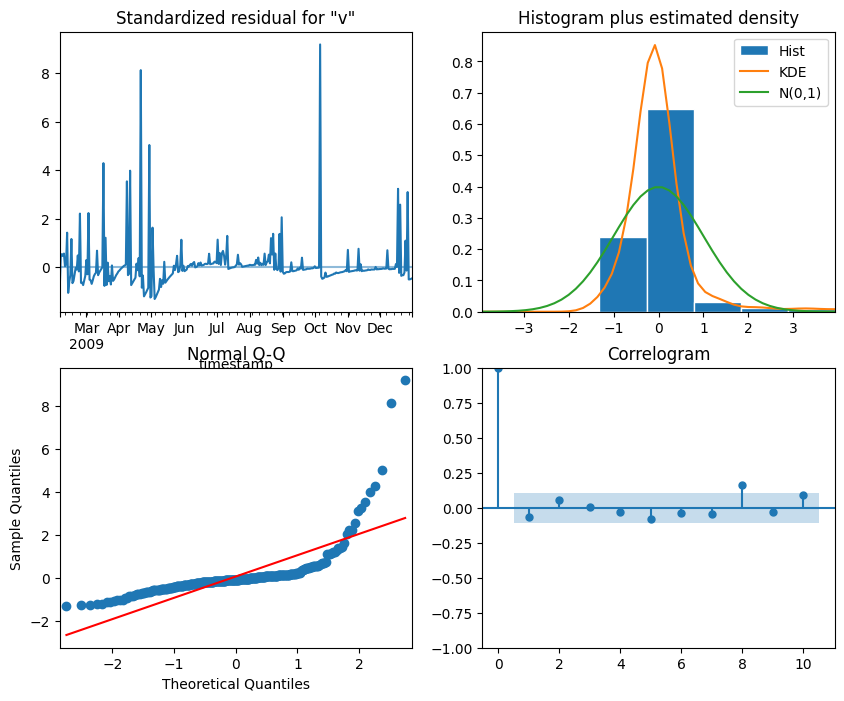

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  333
Model:                 ARIMA(1, 2, 4)   Log Likelihood               -1387.834
Date:                Sat, 07 Dec 2024   AIC                           2787.667
Time:                        01:11:21   BIC                           2810.480
Sample:                    02-02-2009   HQIC                          2796.766
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      1.757     -0.569      0.569      -4.443       2.443
ma.L1         -1.9565     19.303     -0.101      0.919     -39.790      35.877
ma.L2         -0.0432     39.517     -0.001      0.9

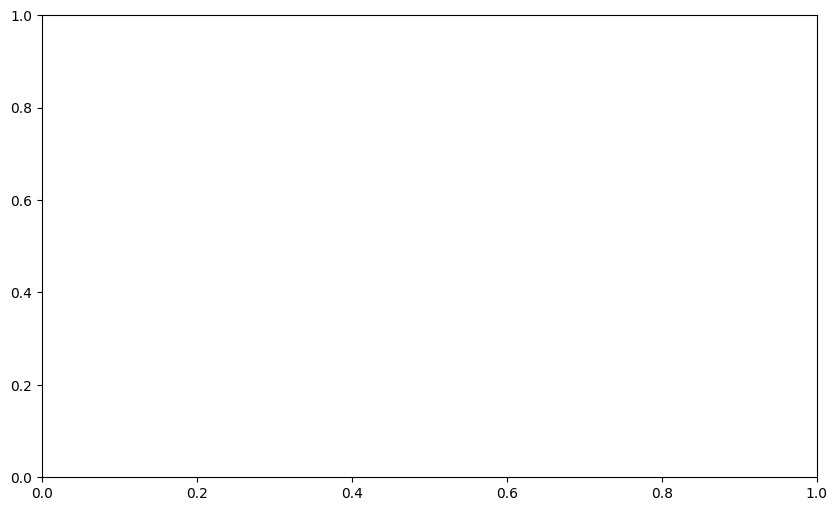

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Parámetros ARIMA
p = 1
d = 2
q = 4

# Ajustar modelo ARIMA
model = ARIMA(diferenciada['value'], order=(p, d, q))
result = model.fit()

# Graficar diagnóstico
result.plot_diagnostics(figsize=(10, 8))
plt.show()

# Realizar predicciones dentro de la muestra (in-sample)
predictions = result.predict(start=d, end=len(diferenciada['value']) - 1)

# Graficar los datos originales y las predicciones
fig, ax = plt.subplots(figsize=(10, 6))
pred_fig = multi_line(Original=diario['value'],Entrenamiento= predictions)

pred_fig.show()

# Resumen del modelo
print(result.summary())


In [13]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(result.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,22.210215,0.014069


In [14]:
#Los valores ajustados del modelo, es decir, las predicciones del modelo para los datos de entrenamiento.
entrenamiento = pd.DataFrame(result.fittedvalues)
entrenamiento.columns = ['value']
fig_ent = multi_line(Original= diario['value'], Entrenamiento = entrenamiento['value'])
fig_ent.show()


In [15]:

from statsmodels.tsa.arima.model import ARIMA
p=1
d=1
q=2


# Ajustar modelo ARIMA
model = ARIMA(diario['value'], order=(p, d, q))
result = model.fit()

# Resumen del modelo
print(result.summary())

# Predicciones
predicciones = result.forecast(steps=10)
print(predicciones)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  334
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1376.722
Date:                Sat, 07 Dec 2024   AIC                           2761.443
Time:                        01:11:21   BIC                           2776.676
Sample:                    02-01-2009   HQIC                          2767.518
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9416      0.097     -9.720      0.000      -1.131      -0.752
ma.L1         -0.0714      0.135     -0.528      0.598      -0.337       0.194
ma.L2         -0.8882      0.117     -7.574      0.0